Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2113 non-null   object 
 1   components_pm2_5           2113 non-null   float64
 2   components_pm10            2113 non-null   float64
 3   aqi                        2113 non-null   float64
 4   hour                       2113 non-null   int64  
 5   day                        2113 non-null   int64  
 6   month                      2113 non-null   int64  
 7   aqi_rolling_mean           2113 non-null   float64
 8   aqi_rolling_std            2113 non-null   float64
 9   aqi_rolling_max            2113 non-null   float64
 10  aqi_rolling_min            2113 non-null   float64
 11  aqi_lag_1                  2113 non-null   float64
 12  aqi_lag_24                 2113 non-null   float64
 13  aqi_lag_48                 2113 n

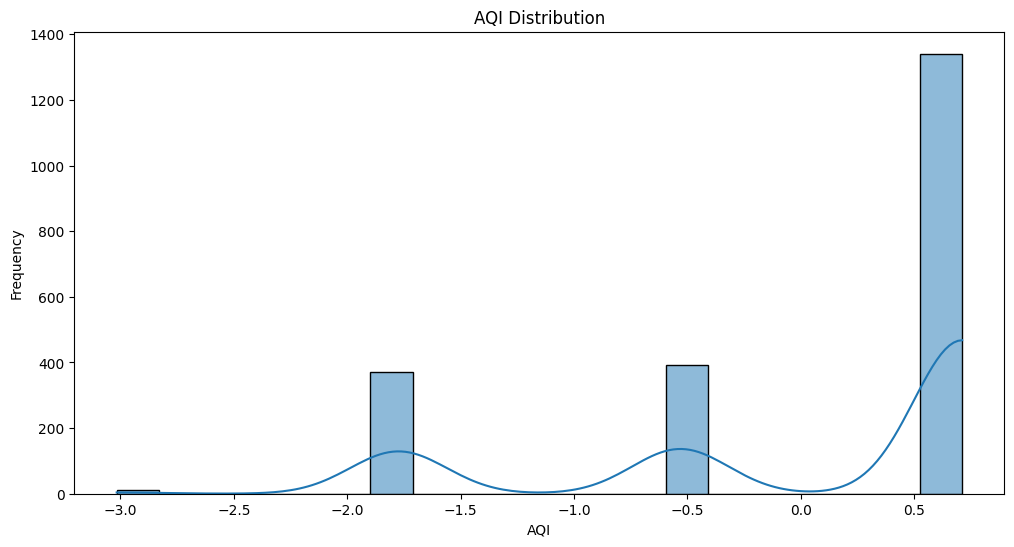

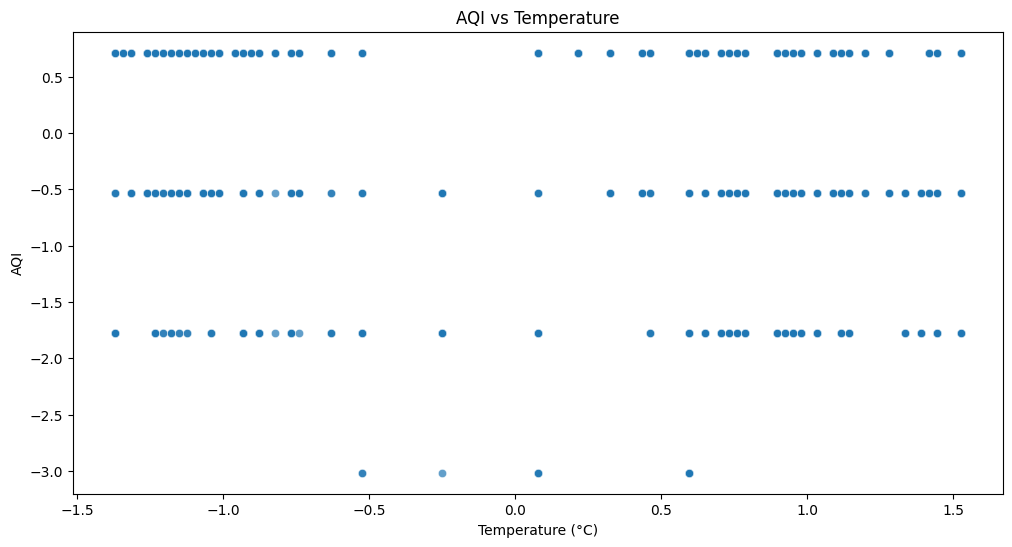

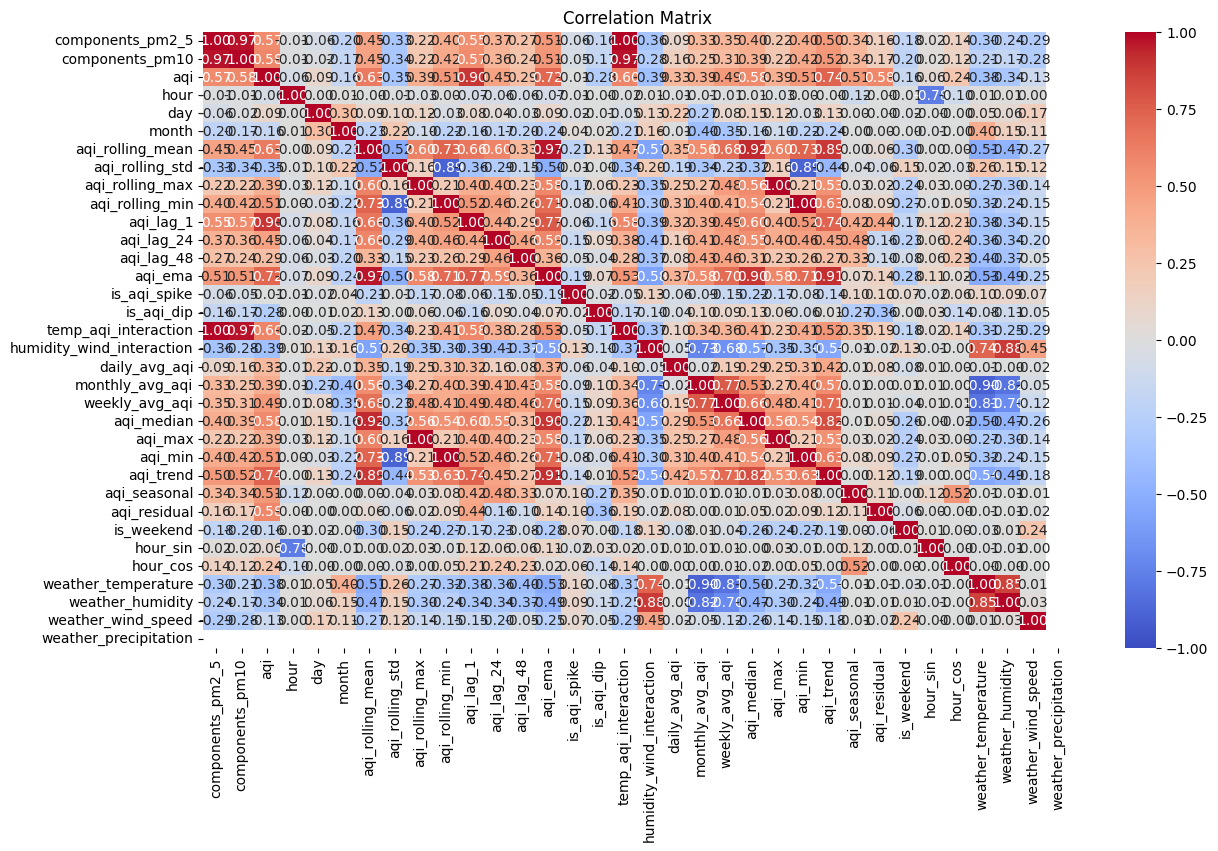

Processed data saved to 'processed_data.csv'.
Random Forest - RMSE: 0.04403006802167648
Random Forest - MAE: 0.004348860040821521
Random Forest - R²: 0.9980992143848837
Top 10 Important Features:
                 Feature  Importance
13          aqi_category    0.693449
16  temp_aqi_interaction    0.300810
1        components_pm10    0.002779
26          aqi_residual    0.001930
0       components_pm2_5    0.000344
8        aqi_rolling_min    0.000262
5       aqi_rolling_mean    0.000101
23               aqi_min    0.000077
21            aqi_median    0.000051
12               aqi_ema    0.000039


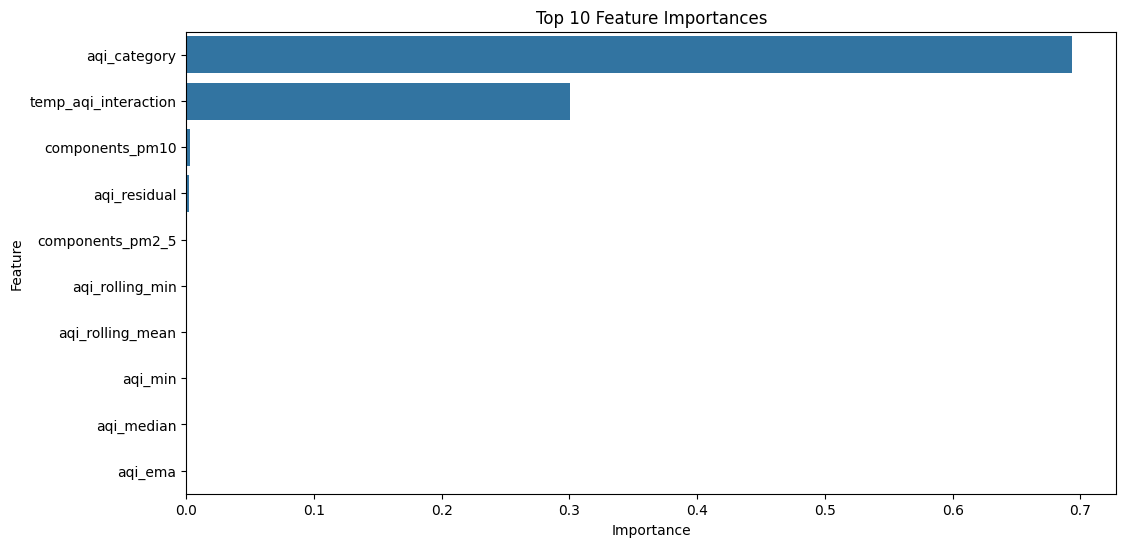

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import sqlite3
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def fetch_data_from_db(db_file, query):
    """Fetches data from SQLite database."""
    try:
        conn = sqlite3.connect(db_file)
        features_df = pd.read_sql_query(query, conn)
        conn.close()
        logging.info("Data successfully fetched from the database.")
        return features_df
    except Exception as e:
        logging.error(f"Error fetching data from database: {e}")
        raise

def validate_data(features_df):
    """Validates if required columns exist in the dataframe."""
    required_columns = ["aqi", "date"]
    missing_columns = [col for col in required_columns if col not in features_df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    logging.info("All required columns are present in the data.")

def plot_univariate(features_df, column, title, xlabel, ylabel):
    """Plots a histogram for univariate analysis."""
    plt.figure(figsize=(12, 6))
    sns.histplot(features_df[column], bins=20, kde=True, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_bivariate(features_df, x_column, y_column, title, xlabel, ylabel):
    """Plots a scatterplot for bivariate analysis."""
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=features_df, x=x_column, y=y_column, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_correlation_matrix(numeric_features_df):
    """Plots a heatmap for the correlation matrix."""
    plt.figure(figsize=(14, 8))
    correlation_matrix = numeric_features_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

def process_data(features_df):
    """Processes data for modeling, including missing value handling and encoding."""
    X = features_df.drop(columns=["aqi", "date"])
    y = features_df["aqi"]

    # Handle missing values
    numeric_columns = X.select_dtypes(include=["number"]).columns
    non_numeric_columns = X.select_dtypes(exclude=["number"]).columns

    X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())
    X[non_numeric_columns] = X[non_numeric_columns].fillna("Unknown")

    # Label encode non-numeric columns
    label_encoders = {}
    for col in non_numeric_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    logging.info("Data processing complete.")
    return X, y

def train_and_evaluate_model(X, y):
    """Trains a Random Forest model and evaluates it."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    logging.info(f"Random Forest - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    logging.info(f"Random Forest - MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    logging.info(f"Random Forest - R²: {r2_score(y_test, y_pred):.2f}")

    return rf_model

def plot_feature_importances(rf_model, feature_names):
    """Plots the top 10 feature importances."""
    feature_importances = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    logging.info("Top 10 Important Features:")
    logging.info(feature_importances.head(10))

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importances.head(10), palette="viridis")
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

def main():
    db_file = "feature_store.db"
    query = "SELECT * FROM features"

    # Step 1: Fetch data
    features_df = fetch_data_from_db(db_file, query)

    # Step 2: Validate data
    validate_data(features_df)

    # Step 3: Exploratory Data Analysis (EDA)
    logging.info("Starting EDA...")
    plot_univariate(features_df, "aqi", "AQI Distribution", "AQI", "Frequency")
    plot_bivariate(features_df, "weather_temperature", "aqi", "AQI vs Temperature", "Temperature (°C)", "AQI")
    numeric_features_df = features_df.select_dtypes(include=[np.number])
    plot_correlation_matrix(numeric_features_df)

    # Step 4: Data Processing
    X, y = process_data(features_df)

    # Step 5: Train and Evaluate Model
    rf_model = train_and_evaluate_model(X, y)

    # Step 6: Feature Importance
    plot_feature_importances(rf_model, X.columns)

if __name__ == "__main__":
    main()
